# Examine Clusters

In [9]:
import os
from decouple import config
import second_level_functions as slf
import numpy as np
import pandas as pd
import ptitprince as pt
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

Change task and contrast to examine clusters

In [10]:
task = 'happy'
contrast = 'interaction'

Read in images and get parameter estimates

In [11]:
base_dir = config(task)
path = os.path.join(base_dir, '2ndlevel')
copes_dir = os.path.join(base_dir, '2ndlevel', 'mixed_model')
parameter_estimates_df = slf.get_peak_voxel(base_dir, path, copes_dir, contrast)

## Plot and get mean of parameter estimates

Split parameter estimates by group and time point. Then get mean of each group and at in each time point

In [12]:
group_values = {
                'an_t1': parameter_estimates_df.loc[(parameter_estimates_df['group'] == 'AN') 
                                                      & (parameter_estimates_df['time_point'] == 't1')].iloc[:, 4:],
                'an_t2':  parameter_estimates_df.loc[(parameter_estimates_df['group'] == 'AN') 
                                                     & (parameter_estimates_df['time_point'] == 't2')].iloc[:, 4:],
                'hc_t1': parameter_estimates_df.loc[(parameter_estimates_df['group'] == 'HC') 
                                                    & (parameter_estimates_df['time_point'] == 't1')].iloc[:, 4:],
                'hc_t2': parameter_estimates_df.loc[(parameter_estimates_df['group'] == 'HC') 
                                                    & (parameter_estimates_df['time_point'] == 't2')].iloc[:, 4:]
}

In [13]:
means_std_df = pd.DataFrame(data={
    'AN T1 mean':  group_values['an_t1'].mean(),
    'AN T1 std':  group_values['an_t1'].std(),
    'HC T1 mean': group_values['hc_t1'].mean(),
    'HC T1 std': group_values['hc_t1'].std(),
    'AN T2 mean': group_values['an_t2'].mean(),
    'AN T2 std':  group_values['an_t2'].std(),
    'HC T2 mean': group_values['hc_t2'].mean(),
    'HC T2 std': group_values['hc_t2'].std(),
    'AN overall mean': pd.concat((group_values['an_t1'], group_values['an_t2'])).mean(),
    'AN overall std': pd.concat((group_values['an_t1'], group_values['an_t2'])).std(),
    'HC overall mean': pd.concat((group_values['hc_t1'], group_values['hc_t2'])).mean(),
    'HC overall std': pd.concat((group_values['hc_t1'], group_values['hc_t2'])).std(),
    'T1 overall mean': pd.concat((group_values['an_t1'], group_values['hc_t1'])).mean(),
    'T1 overall std': pd.concat((group_values['an_t1'], group_values['hc_t1'])).std(),
    'T2 overall mean': pd.concat((group_values['hc_t2'], group_values['an_t2'])).mean(),
    'T2 overall std': pd.concat((group_values['an_t2'], group_values['hc_t2'])).std()
                   }).T
means_std_df

,Vermis_4_5
AN T1 mean,1.808552
AN T1 std,1.771879
HC T1 mean,2.971905
HC T1 std,2.551519
AN T2 mean,2.511060
AN T2 std,2.332078
HC T2 mean,1.221835
HC T2 std,0.827403
AN overall mean,2.159806
AN overall std,2.092883


Plot parameter estimates

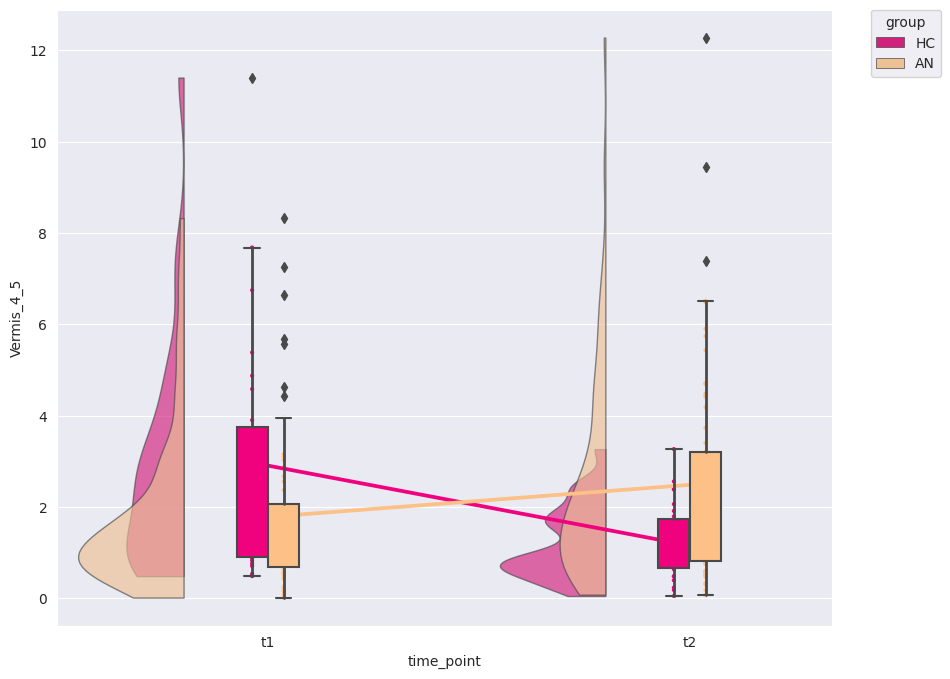

In [14]:
for cluster in means_std_df.columns:
    fig,ax = plt.subplots(1,1, figsize=(10, 8))
    pt.RainCloud(
        x="time_point", 
        y=cluster, 
        hue="group", 
        data=parameter_estimates_df, 
        palette='Accent_r', 
        alpha=.65, 
        dodge=True, 
        scale="area",
        ax=ax,
        width_viol=.5,
        jitter=0,
        pointplot = True,
        bw=.3
         )



## Linear Mixed Model

Change reference level of model by changing the name of AN to participant with AN (pAN) and HC to Control

In [15]:
regression_df = parameter_estimates_df
regression_df['group'] = regression_df['group'].apply(lambda group: 'pAN' if group == 'AN' else 'Control')

define and fit the model

In [16]:
import IPython.display as display

for cluster in means_std_df.columns:

    model = smf.mixedlm(f"{cluster} ~ time_point + group + group*time_point", 
                        regression_df, 
                        groups=regression_df["sub"]).fit()
    model.summary()
    
    summ = pd.concat((model.params.to_frame().T.rename(index={0: 'params'}), 
               model.bse_fe.to_frame().T.rename(index={0: 'std'}))).dropna(axis=1)
    print('-'*100)
    print(cluster)
    display.display(summ)

----------------------------------------------------------------------------------------------------
Vermis_4_5


,Intercept,time_point[T.t2],group[T.pAN],group[T.pAN]:time_point[T.t2]
params,2.971905,-1.750070,-1.163353,2.452579
std,0.389171,0.476889,0.462997,0.567355
